# Analyzing multiple states

`lnpy` is designed to analyze $\ln \Pi(N)$ at a single state point (temperature, volume, etc) across multiple values of $\ln z$.  To analyze across multiple state points, some extra work is required.  Here, we show an example of analyzing $\ln \Pi(N; T)$ for several values of the temperature $T$.

In [1]:
%matplotlib inline

import json

# load reference states

In [2]:
from pathlib import Path

import numpy as np
import xarray as xr
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import lnpy


def load_lnpi_from_json(path):
    with open(path) as f:
        ds = xr.Dataset.from_dict(json.load(f))

        if "PE" in ds:
            extra_kws = {"PE": ds.PE.values}
        else:
            extra_kws = None

        ref = lnpy.lnPiMasked.from_dataarray(ds.lnpi, extra_kws=extra_kws)
    return ref


refs = [load_lnpi_from_json(p) for p in Path("./tmmc_json/").glob("*.json")]

# analyze a single lnpi

In [103]:
# function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError("bad tag function")
    else:
        argmax0 = np.array([xx.local_argmax()[0] for xx in x])
        if len(x) == 2:
            return np.argsort(argmax0)
        else:
            return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


def get_stability(
    ref, nphase=2, ret_all=True, get_spin=True, tag_phases=tag_phases2, nlnz=2
):
    phase_creator = lnpy.PhaseCreator(
        nmax=nphase,
        nmax_peak=4,
        ref=ref,
        merge_kws={"efac": 0.5},
        tag_phases=tag_phases,
    )
    build_phases = phase_creator.build_phases_mu([None])

    # Turn off parallel here
    with lnpy.set_options(joblib_use=False, tqdm_use=False):
        # If want nice mesh
        #         c_course, c = limited_collection(
        #             build_phases,
        #             dlnz=2.0,
        #             digits=3,
        #             offsets=[-10, +10],
        #             collection_kws=dict(unstack=False),
        #             edge_distance_min=8,
        #             dens_min=1e-6

        #         )

        # For rough estimate, use something like:
        # NOTE: using a finer mesh like above might make calculation more accurate...
        lnzs = np.linspace(-10, +10, nlnz) + ref.lnz[0]
        c_course = lnpy.lnPiCollection.from_builder(
            lnzs=lnzs, build_phases=build_phases, unstack=False
        )

        # calculate spinodal
        efac = 1.0
        stability_kws = {
            "phase_ids": 2,
            "build_phases": build_phases,
            "build_kws": {"efac": efac * 0.5},
            "as_dict": False,
            "inplace": False,
        }

        spin = bino = None
        if get_spin:
            try:
                spin, spin_info = c_course.spinodal(efac=efac, **stability_kws)
                bino, bino_info = c_course.binodal(spinodals=spin, **stability_kws)
            except:
                pass
        else:
            try:
                bino, bino_info = c_course.binodal(
                    lnz_min=lnzs[0], lnz_max=lnzs[-1], **stability_kws
                )
            except:
                pass

    out = {
        "spin": spin,
        "bino": bino,
    }

    if ret_all:
        out["phase_creator"] = phase_creator
        out["c_course"] = c_course

    return out

In [64]:
# super simple construction
ref = refs[0]
phase_creator = lnpy.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.5}, tag_phases=None
)

c_course = lnpy.lnPiCollection.from_builder(
    lnzs=np.linspace(-10, +10, 2) + ref.lnz[0],
    build_phases=phase_creator.build_phases_mu([None]),
)

In [66]:
c_course.binodal.__call__(
    phase_ids=2,
    build_phases=out["phase_creator"].build_phases_mu([None]),
    build_kws={"efac": 0.5},
    as_dict=False,
    inplace=False,
    lnz_min=-10,
    lnz_max=+10,
)

(<class lnPiCollection>
 binodal  lnz_0         phase
 0        1.136868e-12  1        [1.1368683772161603e-12]
 dtype: object,
 {0:       converged: True
             flag: 'converged'
   function_calls: 45
       iterations: 44
             root: 1.1368683772161603e-12})

In [128]:
%timeit -n 1 -r 1 [get_stability(ref, tag_phases=tag_phases2, get_spin=True) for ref in refs]

2.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [142]:
print("parallel")
f = lambda ref: get_stability(ref=ref, tag_phases=tag_phases2, get_spin=True, nlnz=5)
%timeit -n 1 -r 1 Parallel(n_jobs=-1)(delayed(f)(ref) for ref in refs)

parallel
530 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [143]:
# accumulate stabilities
stabilities = Parallel(n_jobs=-1)(delayed(get_stability)(ref) for ref in tqdm(refs))

  0%|          | 0/15 [00:00<?, ?it/s]

In [144]:
# Collect all binodals and drop any with None (super crit)
binodals = [bino for s in stabilities if (bino := s["bino"]) is not None]

In [145]:
# collect properties and concat
table = xr.concat(
    [b.xge.table(keys=["dens_tot", "pressure"]) for b in binodals], dim="sample"
)

In [146]:
df = table.reset_index("sample").to_dataframe()

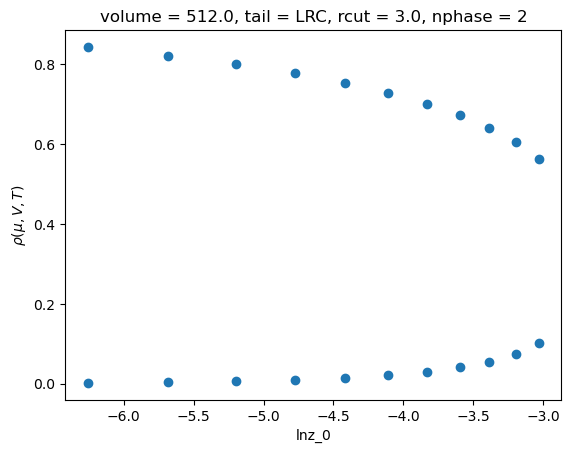

In [147]:
table.plot.scatter("lnz_0", "dens_tot")

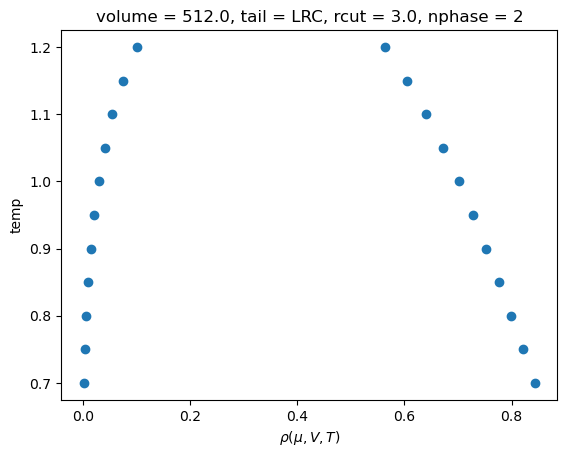

In [148]:
table.plot.scatter("dens_tot", "temp")